<h1 style="color: #5ca3d6; text-align: center;">Classifying Severity of Alzheimer's Disease - CNN</h1>

In [1]:
import numpy as np
import cv2
import os
import seaborn as sns
import pandas as pd

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import copy

from gradcam import apply_gradcam

<h3 style="font-weight: normal;">Constants</h3>

In [2]:
DATASET_PATH = '..' + os.path.sep + 'dataset'
IMAGE_SIZE = (128, 128)

<h3 style="font-weight: normal;">Reading image paths and labels and writing to dictionary</h3>

Iterrating through dataset's directories and files and creating dictionary with <span style="font-style: italic;">"path/to/file" : "label"</span> pairs. <br/>
Also, creating classes list, which is a list with names of all classes. Possible Alzheimer stages (classes) are: non demented, mild demented, very mild demented and moderate demented.

In [3]:
images_dict = dict()
classes = []

for root, dirs, files in os.walk(DATASET_PATH):
    path = root.split(os.sep)
    for directory in dirs:
        classes.append(directory)

    for file in files:
        if len(path) == 3:
            if path[2] == 'MildDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 0
            elif path[2] == 'ModerateDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 1
            elif path[2] == 'NonDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 2
            elif path[2] == 'VeryMildDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 3

class_number = len(classes)
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

<h3 style="font-weight: normal;">Loading images</h3>

Creating two lists: <span style="font-style: italic;">train_images</span>, which is a list of loaded images, and <span style="font-style: italic;">train_image_labels</span>, which is a list of labels for each image.

In [4]:
train_images = []
train_image_labels = []

for image_path, image_label in images_dict.items():
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    train_images.append(img)
    train_image_labels.append(image_label)
    # print(image_path)

train_images = np.asarray(train_images)
train_image_labels = np.asarray(train_image_labels)

<h3 style="font-weight: normal;">Split to train and test</h3>

In [5]:
train_images, test_images, train_image_labels, test_image_labels = train_test_split(
    train_images,
    train_image_labels,
    test_size=0.2,
    random_state=15,
    stratify=train_image_labels)

# Copying images for visualizing via heatmaps
test_images_for_heatmaps = copy.deepcopy(test_images[0::60])

train_images = train_images / 255
test_images = test_images / 255

<h3 style="font-weight: normal;">Oversampling</h3>

In [6]:
sm = SMOTE(random_state=42)
train_images, train_image_labels = sm.fit_resample(train_images.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3), 
                                                   train_image_labels)
train_images = train_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)


test_images, test_image_labels = sm.fit_resample(test_images.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3), 
                                                 test_image_labels)
test_images = test_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

<h3 style="font-weight: normal;">Shuffling data</h3>

In [7]:
train_images, train_image_labels = shuffle(train_images, train_image_labels)

<h3 style="font-weight: normal;">Creating and training model</h3>

In [8]:
try:
    model = load_model('models/cnn-rgb.h5')
except:
    model = Sequential()
    
    model.add(Conv2D(input_shape=IMAGE_SIZE+(3,), filters=64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=class_number, activation='softmax'))
    
    model.summary()

    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_images, train_image_labels, epochs=15, verbose=1)
    model.save('models/cnn-rgb.h5')

    # Plotting accuracy and loss during training
    # accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

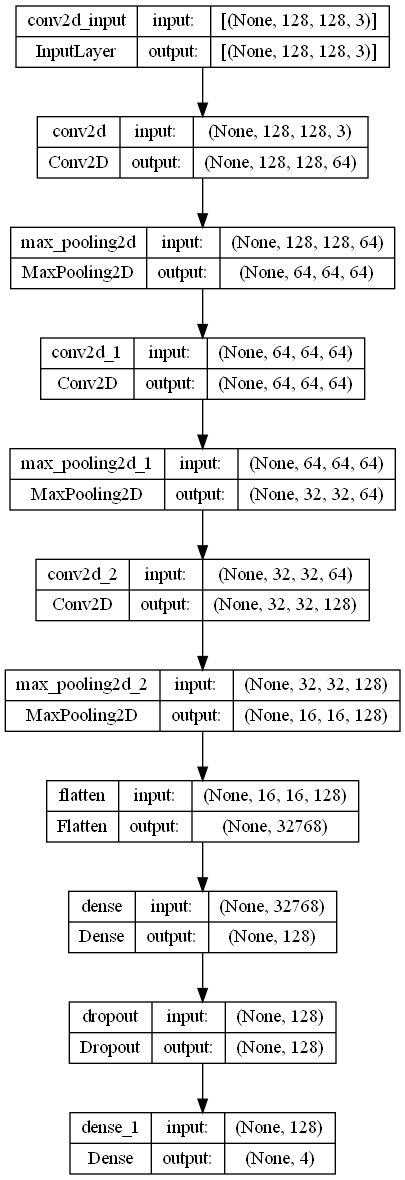

In [9]:
keras.utils.plot_model(model, to_file="models/model_plot.png", show_shapes=True, show_layer_names=True)

<h3 style="font-weight: normal;">Evaluating and predicting</h3>

In [10]:
# Evaluating
results = model.evaluate(test_images, test_image_labels)
print("test loss, test acc:", results)

# Predicting
predictions = model.predict(test_images)
print(predictions)

predicted_labels = []
for prediction in predictions:
    predicted_value = max(prediction)
    index = np.where(prediction == predicted_value)[0][0]
    predicted_labels.append(index)

80/80 [==============================] - 15s 177ms/step - loss: 0.1342 - accuracy: 0.9777
test loss, test acc: [0.13419587910175323, 0.977734386920929]
80/80 [==============================] - 14s 177ms/step
[[2.81845991e-10 3.19473967e-13 9.99994159e-01 5.88961802e-06]
 [9.96666849e-01 7.53468399e-08 1.61173943e-04 3.17186047e-03]
 [1.79146689e-22 3.29047413e-24 1.00000000e+00 3.01756233e-13]
 ...
 [1.12823784e-07 3.82650946e-15 1.36827140e-07 9.99999762e-01]
 [4.46794672e-07 1.26459555e-11 2.47801836e-05 9.99974728e-01]
 [2.08907505e-08 4.36699743e-08 2.53821731e-01 7.46178269e-01]]


<h3 style="font-weight: normal;">Statistics</h3>

In [11]:
test_image_labels_str = []
for label in test_image_labels:
    test_image_labels_str.append(classes[int(label)])
predicted_labels_str = []
for label in predicted_labels:
    predicted_labels_str.append(classes[label])

<h4 style="font-weight: normal;">Confusion matrix</h4>

[[603   0   8  29]
 [  0 634   5   1]
 [  0   0 637   3]
 [  0   0  11 629]]


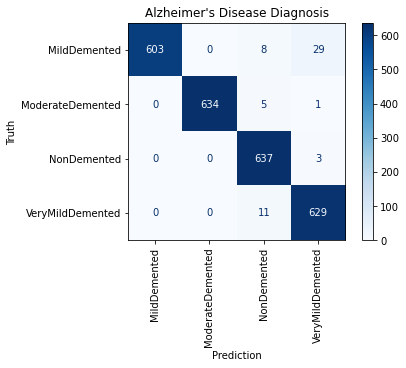

In [12]:
conf_mat = confusion_matrix(test_image_labels_str, predicted_labels_str, labels=classes)
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(cmap="Blues", values_format='', xticks_rotation=90)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

<h4 style="font-weight: normal;">Accuracy</h4>

In [13]:
percentage = accuracy_score(test_image_labels_str, predicted_labels_str)*100
print('Accuracy:', percentage, '%')

Accuracy: 97.7734375 %


<h4 style="font-weight: normal;">Classification report</h4>

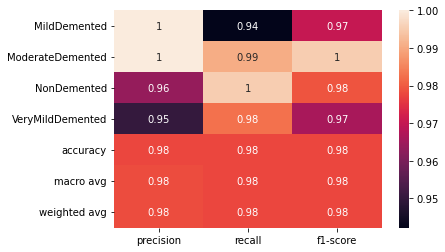

In [14]:
clf_report = classification_report(y_true=list(map(str, test_image_labels_str)),
                            y_pred=list(map(str, predicted_labels_str)),
                            target_names=list(map(str, classes)),
                            output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

<h2 style="font-weight: normal;">Heat Maps</h2>

1/1 [==============================] - 0s 136ms/step


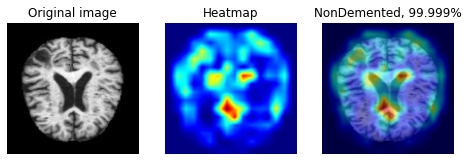

1/1 [==============================] - 0s 22ms/step


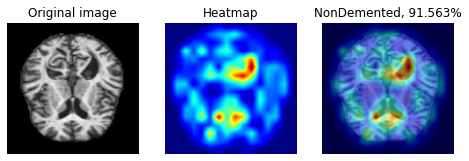

1/1 [==============================] - 0s 25ms/step


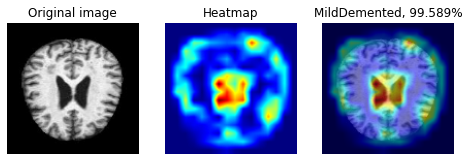

1/1 [==============================] - 0s 24ms/step


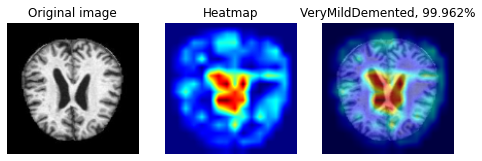

1/1 [==============================] - 0s 23ms/step


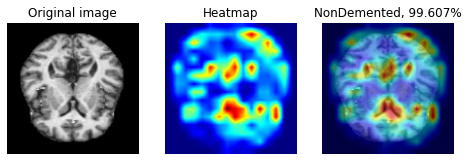

1/1 [==============================] - 0s 25ms/step


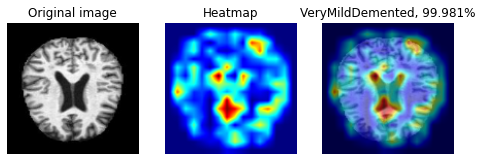

1/1 [==============================] - 0s 22ms/step


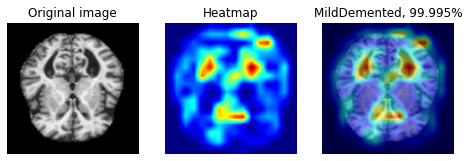

1/1 [==============================] - 0s 25ms/step


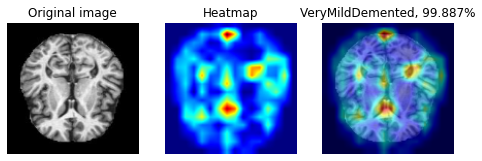

1/1 [==============================] - 0s 23ms/step


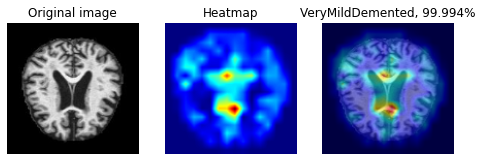

1/1 [==============================] - 0s 22ms/step


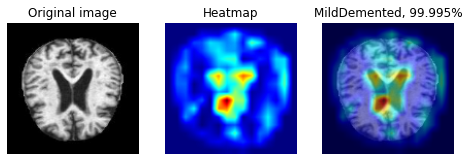

1/1 [==============================] - 0s 23ms/step


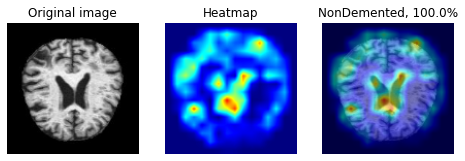

1/1 [==============================] - 0s 25ms/step


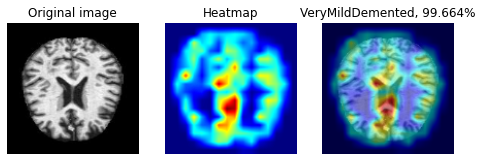

1/1 [==============================] - 0s 22ms/step


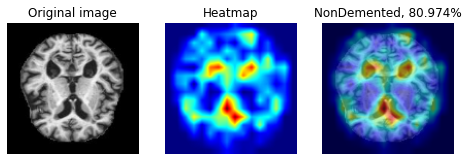

1/1 [==============================] - 0s 26ms/step


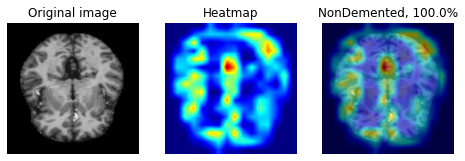

1/1 [==============================] - 0s 24ms/step


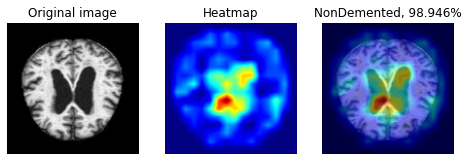

1/1 [==============================] - 0s 22ms/step


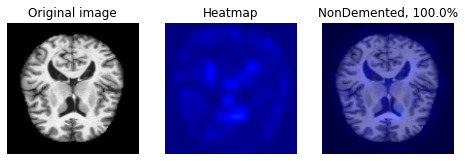

1/1 [==============================] - 0s 25ms/step


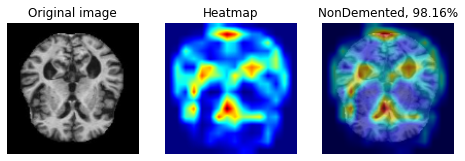

1/1 [==============================] - 0s 25ms/step


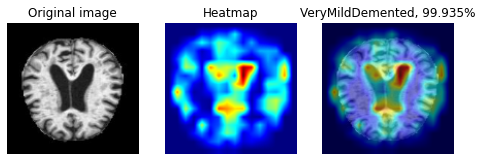

1/1 [==============================] - 0s 22ms/step


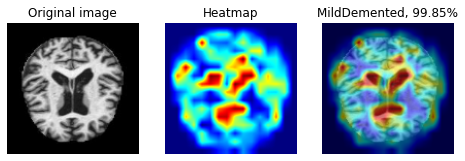

1/1 [==============================] - 0s 31ms/step


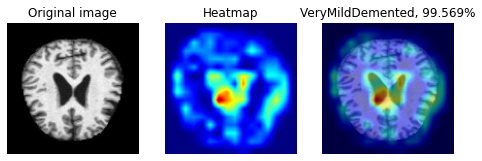

1/1 [==============================] - 0s 25ms/step


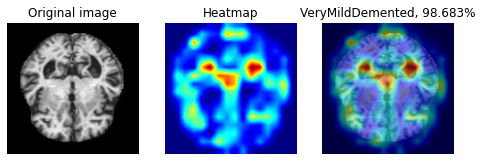

1/1 [==============================] - 0s 29ms/step


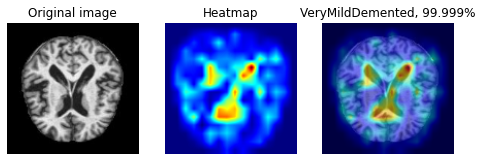

In [15]:
apply_gradcam(model, classes, test_images_for_heatmaps)